In [19]:
import torch
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import resnet50
from torch.utils.data import DataLoader
sys.path.append('..')
import scripts.make_dataset as dataset_module
import scripts.model as model_module
import scripts.fusion_model as fusion_model
import pickle

def get_modality_residuals(modality, test_loader, device='cpu'):
    # 1. Reconstruct and Load Model
    model = resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(f'../models/dl_model_{modality}.pth', map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_trues = []

    # 2. Run Inference
    with torch.no_grad():
        for images, ages in test_loader:
            images = images.to(device)
            outputs = model(images)
            all_preds.extend(outputs.squeeze().cpu().numpy())
            all_trues.extend(ages.cpu().numpy())

    all_preds = np.array(all_preds)
    all_trues = np.array(all_trues)
    
    # 3. Calculate Residuals: Actual - Predicted
    # Positive = Underestimated (Model thought they were younger)
    # Negative = Overestimated (Model thought they were older)
    residuals = all_trues - all_preds
    
    return all_trues, all_preds, residuals

def plot_residual_analysis(results_dict):
    """
    results_dict: { 'T1': (trues, preds, resids), ... }
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, (modality, (trues, preds, resids)) in enumerate(results_dict.items()):
        # Plot Residual vs Actual Age
        axes[i].scatter(trues, resids, alpha=0.5)
        axes[i].set_title(f'{modality} Residual Plot')
        axes[i].set_xlabel('True Age')
        axes[i].set_ylabel('Residual (True - Pred)')
        axes[i].axhline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()

592 total records in CSV
550 records after dropping missing and duplicate filenames/ages
Train size: 330, Val size: 110, Test size: 110


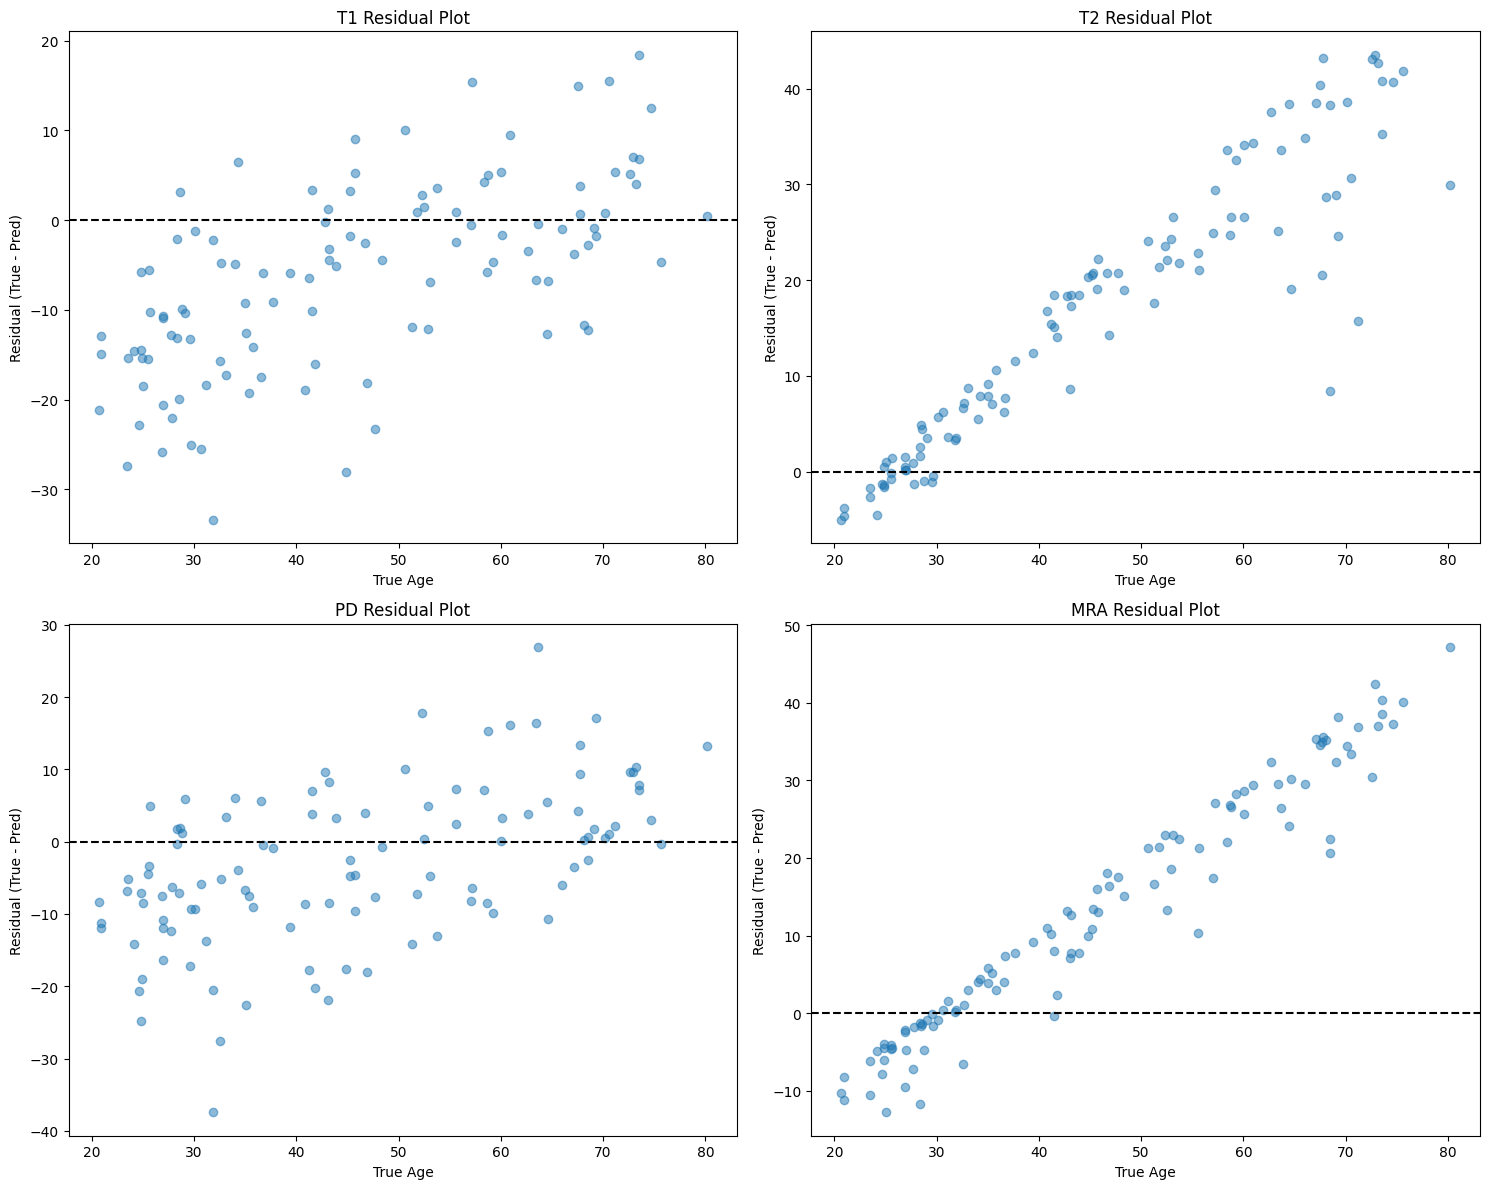

In [11]:
modalities = ['T1', 'T2', 'PD', 'MRA']
all_results = {}
dl_datasets = dataset_module.create_datasets(type='files')
test_transform = model_module.build_transforms()[2]  # Test transform

for mod in modalities:
    # Use your existing dataset building logic to get the test split
    _, _, _, _, X_test, y_test = dl_datasets[mod]#[4:] # Adjust indices based on your split tuple
    
    test_ds = model_module.MRIImageDataset(X_test, y_test, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=32, num_workers=0)
    
    all_results[mod] = get_modality_residuals(mod, test_loader)

plot_residual_analysis(all_results)

In [12]:
from sklearn.linear_model import LinearRegression

def get_bias_correction_params(y_true, y_pred):
    """
    Fit a line: y_pred = alpha * y_true + beta
    """
    model = LinearRegression()
    model.fit(y_true.reshape(-1, 1), y_pred)
    alpha = model.coef_[0]
    beta = model.intercept_
    return alpha, beta

def apply_correction(y_pred, alpha, beta):
    """
    Apply the correction formula to shift predictions back.
    """
    return (y_pred - beta) / alpha

In [15]:
modalities = ['T1', 'T2', 'PD', 'MRA']
all_results = {}
dl_datasets = dataset_module.create_datasets(type='files')
test_transform = model_module.build_transforms()[2]  # Test transform
val_transform = model_module.build_transforms()[1]

for mod in modalities:
    # Use your existing dataset building logic to get the test split
    _, _, X_val, y_val, X_test, y_test = dl_datasets[mod]#[4:] # Adjust indices based on your split tuple
    
    val_ds = model_module.MRIImageDataset(X_val, y_val, transform=val_transform)
    val_loader = DataLoader(val_ds, batch_size=32, num_workers=0)
    test_ds = model_module.MRIImageDataset(X_test, y_test, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=32, num_workers=0)

    # 1. Get Val residuals to find the bias
    val_trues, val_preds, _ = get_modality_residuals(mod, val_loader)
    alpha, beta = get_bias_correction_params(val_trues, val_preds)

    # 2. Get Test residuals
    test_trues, test_preds, _ = get_modality_residuals(mod, test_loader)

    # 3. Apply Correction to Test Predictions
    corrected_test_preds = apply_correction(test_preds, alpha, beta)
    corrected_residuals = test_trues - corrected_test_preds

    print(f"Modality: {mod} | Alpha (Slope): {alpha:.3f} | Beta (Intercept): {beta:.3f}")

    # 4. Compare Metrics
    from sklearn.metrics import mean_absolute_error
    old_mae = mean_absolute_error(test_trues, test_preds)
    new_mae = mean_absolute_error(test_trues, corrected_test_preds)

    print(f"Original MAE: {old_mae:.2f}")
    print(f"Corrected MAE: {new_mae:.2f}")

592 total records in CSV
550 records after dropping missing and duplicate filenames/ages
Train size: 330, Val size: 110, Test size: 110
Modality: T1 | Alpha (Slope): 0.594 | Beta (Intercept): 22.646
Original MAE: 9.75
Corrected MAE: 11.25
Modality: T2 | Alpha (Slope): 0.155 | Beta (Intercept): 21.436
Original MAE: 17.09
Corrected MAE: 21.39
Modality: PD | Alpha (Slope): 0.670 | Beta (Intercept): 18.132
Original MAE: 8.91
Corrected MAE: 10.75
Modality: MRA | Alpha (Slope): 0.079 | Beta (Intercept): 29.858
Original MAE: 15.75
Corrected MAE: 35.22


In [17]:
def get_fusion_residuals(model_path, test_loader, device='cpu'):
    # 1. Reconstruct and Load the Fusion Model
    # Assumes the LateFusionBrainAgeModel class is defined in your script
    model = fusion_model.LateFusionBrainAgeModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_trues = []

    # 2. Run Inference
    with torch.no_grad():
        for t1, t2, pd, mra, ages in test_loader:
            # Move all 4 images to device
            t1, t2 = t1.to(device), t2.to(device)
            pd, mra = pd.to(device), mra.to(device)
            ages = ages.to(device)
            
            # Forward pass through all 4 branches
            outputs = model(t1, t2, pd, mra)
            
            # Use flatten() to ensure we have a 1D array of predictions
            all_preds.extend(outputs.view(-1).cpu().numpy())
            all_trues.extend(ages.cpu().numpy())

    all_preds = np.array(all_preds)
    all_trues = np.array(all_trues)
    
    # 3. Calculate Residuals: Actual - Predicted
    residuals = all_trues - all_preds
    
    return all_trues, all_preds, residuals

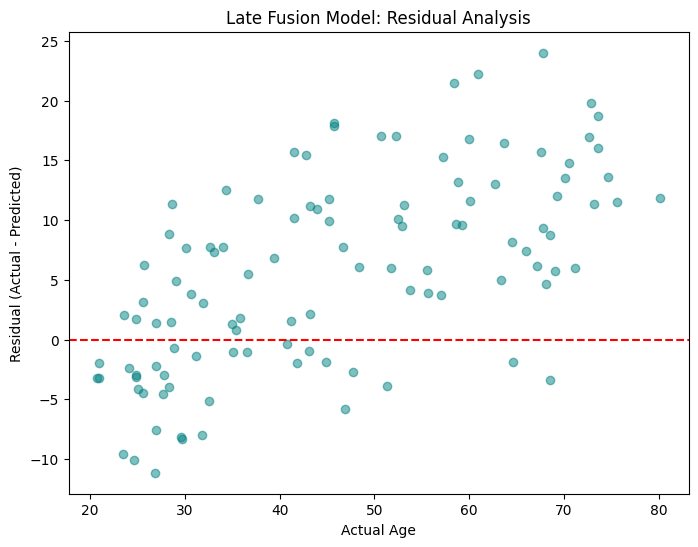

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_df = pd.read_csv('val_split.csv')
test_df = pd.read_csv('test_split.csv')

test_ds_fusion = fusion_model.MultiModalBrainDataset(test_df, "../data/raw", transform=test_transform)
test_loader_fusion = DataLoader(test_ds_fusion, batch_size=16, shuffle=False)

# 2. Get Fusion Residuals
fusion_trues, fusion_preds, fusion_resids = get_fusion_residuals(
    '../models/final_late_fusion_model.pth', 
    test_loader_fusion, 
    device=device
)

# 3. Add to your results dictionary
all_results['FUSION'] = (fusion_trues, fusion_preds, fusion_resids)

# 4. Update Plotting to handle 5 models (or just the Fusion one)
def plot_fusion_comparison(trues, preds, resids):
    plt.figure(figsize=(8, 6))
    plt.scatter(trues, resids, alpha=0.5, color='teal')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Late Fusion Model: Residual Analysis')
    plt.xlabel('Actual Age')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.show()

plot_fusion_comparison(fusion_trues, fusion_preds, fusion_resids)

In [22]:
# 1. Setup the Multi-Modal Loaders (using the DataFrames we defined earlier)
val_ds_fusion = fusion_model.MultiModalBrainDataset(val_df, "../data/raw", transform=val_transform)
val_loader_fusion = DataLoader(val_ds_fusion, batch_size=32, shuffle=False)

test_ds_fusion = fusion_model.MultiModalBrainDataset(test_df, "../data/raw", transform=test_transform)
test_loader_fusion = DataLoader(test_ds_fusion, batch_size=32, shuffle=False)

# 2. Path to your best saved fusion model
fusion_model_path = '../models/final_late_fusion_model.pth'

# 3. Get Validation residuals to find the bias parameters (Alpha and Beta)
# Using the function we built in the previous step
val_trues, val_preds, _ = get_fusion_residuals(fusion_model_path, val_loader_fusion, device=device)
alpha, beta = get_bias_correction_params(val_trues, val_preds)

# 4. Get Test residuals
test_trues, test_preds, _ = get_fusion_residuals(fusion_model_path, test_loader_fusion, device=device)

# 5. Apply Correction to Test Predictions
corrected_test_preds = apply_correction(test_preds, alpha, beta)
corrected_residuals = test_trues - corrected_test_preds

# 6. Store and Print Results
all_results['FUSION_CORRECTED'] = (test_trues, corrected_test_preds, corrected_residuals)

print(f"--- Fusion Model Bias Correction ---")
print(f"Alpha (Slope): {alpha:.3f} | Beta (Intercept): {beta:.3f}")

from sklearn.metrics import mean_absolute_error, r2_score
old_mae = mean_absolute_error(test_trues, test_preds)
new_mae = mean_absolute_error(test_trues, corrected_test_preds)
r2 = r2_score(test_trues, corrected_test_preds)

print(f"Original Fusion MAE: {old_mae:.2f}")
print(f"Corrected Fusion MAE: {new_mae:.2f}")
print(f"Corrected Fusion R²: {r2:.3f}")

--- Fusion Model Bias Correction ---
Alpha (Slope): 0.663 | Beta (Intercept): 8.860
Original Fusion MAE: 8.09
Corrected Fusion MAE: 7.90
Corrected Fusion R²: 0.672
